# PSYCH 239: Week 2: Fully Connected Neural Network for Visual Classification


In [0]:
import torch
from torchvision import datasets, transforms

In [0]:
class toOneHot(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, integer):
        y_onehot = torch.zeros(self.num_classes)
        y_onehot[integer]=1
        return y_onehot

In [3]:
train_set = datasets.MNIST('./data',
                           train=True, download=True,
                           transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                             ]),
                           target_transform = None,)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

  0%|          | 16384/9912422 [00:00<01:34, 104380.74it/s]

9920512it [00:00, 21654106.46it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 327087.64it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5353313.38it/s]                           
8192it [00:00, 121760.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
test_set = datasets.MNIST('./data',
                           train=False, download=True,
                           transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                             ]),
                           target_transform = None,)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

In [0]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout2d(0.5)
        self.pool2 = torch.nn.MaxPool2d((2,2),(2,2))
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

net = LeNet().cuda()

In [0]:
mse_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [0]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [10]:
x,t = next(iter(train_loader))
train_step(x, t, net, opt, mse_loss)

tensor(2.2968, device='cuda:0', grad_fn=<NllLossBackward>)

Make prediction

In [0]:
for x,t in iter(test_loader):   
    y = net(x.cuda()).cpu()

In [16]:
y.argmax(1)

tensor([8, 7, 7, 8, 5, 8, 8, 7, 2, 2, 8, 5, 7, 2, 8, 9, 8, 4, 8, 8, 2, 7, 2, 2,
        5, 8, 5, 2, 8, 8, 4, 8, 5, 2, 7, 7, 2, 2, 2, 8, 8, 7, 8, 5, 2, 4, 8, 7,
        8, 8, 2, 8, 7, 8, 8, 2, 2, 4, 4, 2, 8, 8, 5, 8, 2, 5, 5, 4, 8, 7, 2, 2,
        8, 7, 2, 8, 7, 7, 9, 3, 2, 2, 2, 8, 8, 8, 7, 2, 5, 8, 5, 8, 8, 8, 5, 0,
        7, 8, 8, 8])

Calculate accuracy

In [17]:
torch.mean((t == y.argmax(1)).float())

tensor(0.1700)

Train the network over multiple epochs

In [20]:
acc_hist_train = []
acc_hist_test = []
for epoch in range(5):
    acc_batch = []
    for x,t in iter(train_loader):   
        loss_ = train_step(x, t, net, opt, mse_loss)
        y = net(x.cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_)

    acc_batch = []
    for x,t in iter(test_loader):   
        y = net(x.cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))   

tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward>)


In [23]:
acc_hist_train

[tensor(0.9420),
 tensor(0.9750),
 tensor(0.9802),
 tensor(0.9837),
 tensor(0.9852)]

In [24]:
acc_hist_test

[tensor(0.9639),
 tensor(0.9757),
 tensor(0.9800),
 tensor(0.9780),
 tensor(0.9809)]

We can plot the kernels learned by the CNN

In [31]:
net.conv1 #This is the first convolutional layer

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))

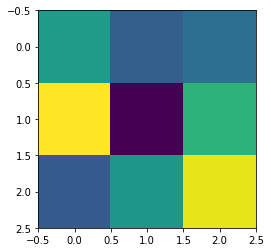

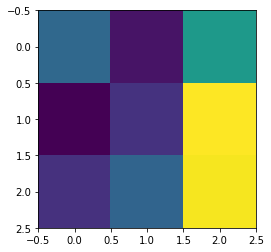

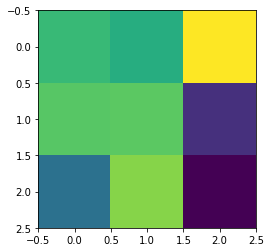

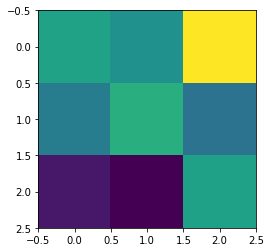

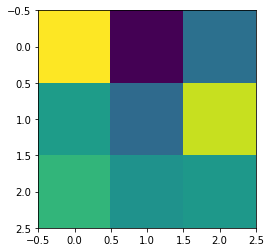

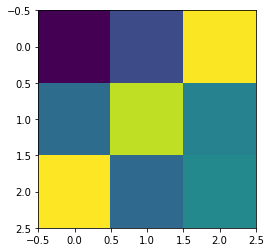

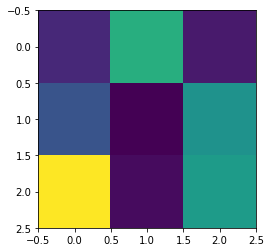

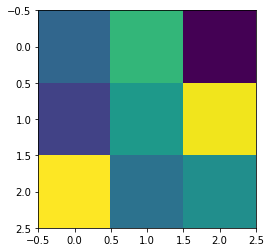

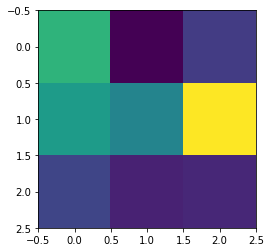

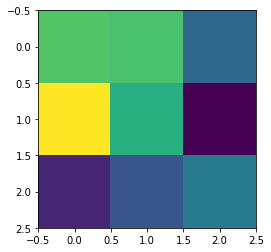

In [33]:
import pylab
for i in range(10):
    pylab.figure();
    pylab.imshow(net.conv1.weight.data[i].cpu().detach().view(3,3))